# Random Forest

In [146]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import folium
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics import log_loss


from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade
import warnings
warnings.filterwarnings('ignore')

In [128]:
data_path = os.path.join(os.getcwd(), 'df_clean.csv')
df_clean = pd.read_csv(data_path, delimiter = ',', encoding='latin-1', decimal=",")
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
df_clean = df_clean[df_clean['Descripcio_victimitzacio']!='Mort']
df_clean['Descripcio_victimitzacio'].unique()

array(['Ferit lleu', 'Ferit greu'], dtype=object)

In [129]:
df_clean2 = df_clean.copy()

# Labels are the values we want to predict
labels_y =  df_clean['Descripcio_victimitzacio'] 
labels_y = labels_y.replace({'Mort': 2}, regex=True)
labels_y = labels_y.replace({'Ferit lleu': 1}, regex=True)
labels_y = labels_y.replace({'Ferit greu': 0}, regex=True)

# Remove the labels from the features
# axis 1 refers to the columns
features_X = df_clean.drop(columns = ['Num_Greus', 'Num_Lleus', 'Num_Morts', 
                                      'Codi_expedient','Descripcio_victimitzacio',
                                     'Descripcio_tipus_persona','Descripcio_tipus_de_vehicle',
                                     'Longitud','Latitud'], axis = 1)
# Saving feature names for later use
feature_list = list(features_X.columns)


num_columns = len(features_X.columns)
pd.set_option("display.max_columns", num_columns)
features_X

,Edat,Codi_barri,Codi_carrer,Hora_de_dia,Mes_de_any,Dia_de_mes,Autobus,Bicicleta,Ciclomotor,Furgoneta,Motocicleta,Taxi,Turisme,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant
0,50,26,187105,4,1,1,0,0,0,0,0,0,1,1,1,47753,26740,2017,8,17,4,3620,0.11435,9.1,70,0.0,2.4,5.5,1,0,0
1,27,6,89004,7,1,1,0,0,0,0,1,0,0,1,2,51651,6904,2017,8,17,1,3058,0.01777,8.0,71,0.0,2.6,4.7,1,0,0
2,34,6,89004,3,8,3,0,0,0,0,0,1,0,1,2,51651,0,2017,6,21,3,3058,0.01777,27.3,74,0.0,0.9,2.9,0,1,0
3,40,66,243206,7,1,1,0,0,1,0,0,0,0,2,3,15204,504,2017,8,17,1,3594,0.03419,8.0,71,0.0,2.6,4.7,0,1,0
4,37,66,243206,7,1,1,0,0,1,0,0,0,0,2,3,15204,504,2017,8,17,1,3594,0.03419,8.0,71,0.0,2.6,4.7,1,0,0
5,35,18,270209,14,1,1,0,0,1,0,0,0,0,1,2,41244,1432,2017,8,17,3,1462,0.10208,13.0,55,0.0,1.9,4.1,1,0,0
6,50,18,270209,16,1,1,0,0,0,0,1,0,0,1,2,41244,5241,2017,8,17,1,1462,0.10208,11.8,61,0.0,1.9,3.9,1,0,0
7,24,18,270209,22,3,24,0,0,0,0,0,1,0,2,2,41244,0,2017,6,19,3,1462,0.10208,6.9,98,3.5,4.9,10.2,0,1,0
8,47,18,270209,22,3,24,0,0,0,0,0,1,0,2,2,41244,0,2017,6,19,3,1462,0.10208,6.9,98,3.5,4.9,10.2,1,0,0
9,29,67,700662,15,1,1,0,1,0,0,0,0,0,1,2,9404,0,2017,8,17,2,1725,0.03664,12.9,56,0.0,1.7,3.9,1,0,0


In [111]:
    # from imblearn.under_sampling import RandomUnderSampler
# und_sample = RandomUnderSampler(ratio=0.75,random_state=1)
# features_X, labels_y = und_sample.fit_sample(features_X, labels_y)

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_X, 
                                                    labels_y, 
                                                    train_size=0.75, 
                                                    random_state = 0)

In [131]:
print('Number of instances in X: {}'.format(np.shape(features_X)[0]))

print('\nNumber of instances in X_train: {}'.format(X_train.shape))
print('Number of instances in X_train: {}'.format(y_train.shape))
print('Number of instances in X_test: {}'.format(X_test.shape))
print('Number of instances in X_test: {}'.format(y_test.shape))


Number of instances in X: 8172

Number of instances in X_train: (6129, 31)
Number of instances in X_train: (6129,)
Number of instances in X_test: (2043, 31)
Number of instances in X_test: (2043,)


In [132]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [133]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 31, svd_solver ='full')  
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)

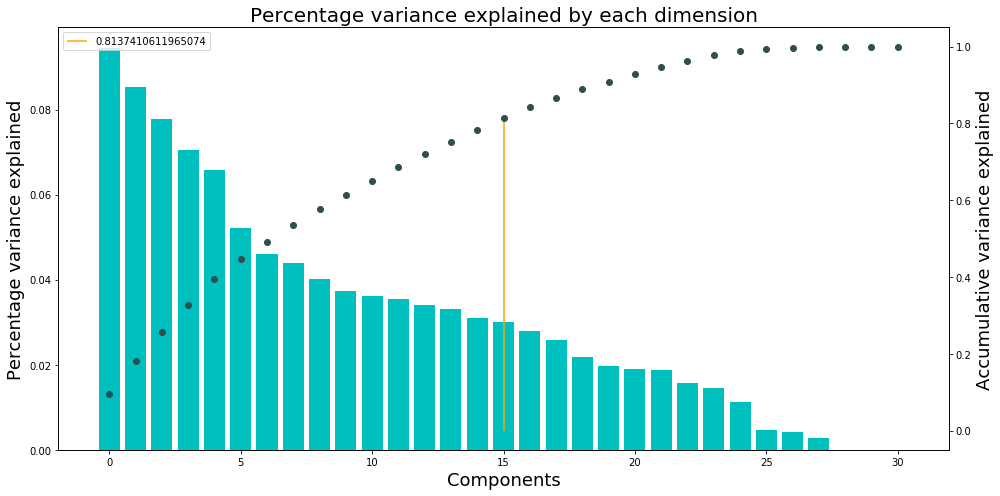

In [134]:
ac_var = 0
x = 0
bar = True

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xlabel('Components',fontsize=18)
plt.ylabel('Percentage variance explained', fontsize=18)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(ac_var)  # we already handled the x-label with ax1
plt.ylabel('Accumulative variance explained', fontsize=18)

while x < X_train_pca.shape[1]:
    ax1.tick_params(axis='y')
    ax1.bar(x, pca.explained_variance_ratio_[x], width=0.8, color="c") #Eigenvalues
    ac_var = pca.explained_variance_ratio_[x] + ac_var
    ax2.plot(x, ac_var, linestyle='-', marker='o',color="darkslategray")
    if ac_var > 0.8 and bar == True:
        plt.vlines(x, 0, ac_var, colors="orange", linestyles='solid', label = ac_var )
        bar = False
    x = x + 1

plt.title('Percentage variance explained by each dimension',fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In some dataset all the features are contributing equally to the overall variance, therefore all the principal components are crucial to the predictions and none can be ignored.

In [117]:
from imblearn.under_sampling import RandomUnderSampler
# und_sample = RandomUnderSampler(ratio=0.5,random_state=42)
# X_train, y_train = und_sample.fit_sample(X_train, y_train)

In [118]:
from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# X_test, y_test = ros.fit_resample(X_test, y_test)

# from collections import Counter
# print(sorted(Counter(y_train_resampled).items()))

In [135]:
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
smt = SMOTETomek(ratio = 0.5 ,random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [136]:
print('Number of instances on the initial X: {}'.format(np.shape(features_X)[0]))

print('\nNumber of instances in X_train: {}'.format(X_train.shape))
print('Number of instances in X_train: {}'.format(y_train.shape))
print('Number of instances in X_test: {}'.format(X_test.shape))
print('Number of instances in X_test: {}'.format(y_test.shape))


Number of instances on the initial X: 8172

Number of instances in X_train: (9009, 31)
Number of instances in X_train: (9009,)
Number of instances in X_test: (2043, 31)
Number of instances in X_test: (2043,)


In [ ]:
param_grid = {
    'max_depth': [20, 40, 50, 70],
#     'max_features': [2, 3],
#      'min_samples_leaf': [3, 4, 5],
    'n_estimators': [20, 50, 100, 500]
}
print( y_train)

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Random forest
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=50,criterion='gini',
                                random_state=0, n_jobs=-1, class_weight="balanced_subsample")

# cv = KFold(X_train.shape[0], n_splits=5, shuffle=True, random_state=0)
# clf_rf = GridSearchCV(clf_rf, param_grid, cv=5, n_jobs=-1)

# Train model
model = clf_rf.fit(X_train, y_train)

In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test,clf_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.33      0.05      0.09        39
           1       0.98      1.00      0.99      2004

   micro avg       0.98      0.98      0.98      2043
   macro avg       0.66      0.52      0.54      2043
weighted avg       0.97      0.98      0.97      2043



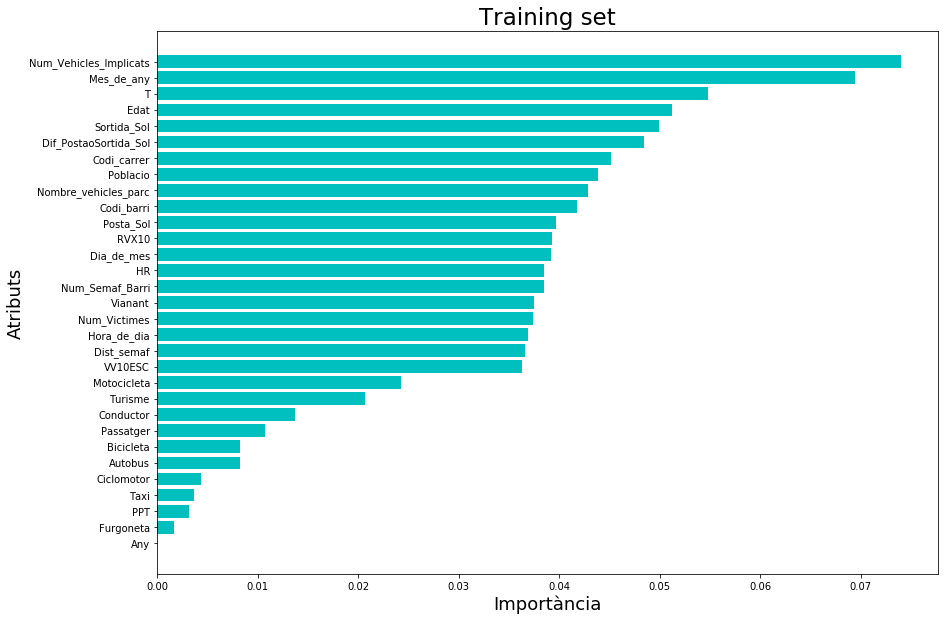

In [139]:
imp = clf_rf.feature_importances_
names = features_X.columns

imp, names = zip(*sorted(zip(imp, names)))

fig = plt.figure(figsize=(14,10))
ax = fig.gca()

plt.barh(range(len(names)),imp, align = 'center', color='c')
plt.yticks(range(len(names)), names)

ax.set_ylabel('Atributs', size = 18)
ax.set_xlabel('Importància', size = 18)
ax.set_title('Training set', size = 23)

plt.show()

The cost-sensitive approach would be to assign different weights to different classes. So if the minority class is assigned a higher weight and thus higher misclassification cost, then that can help reduce its biasness towards the majority class. You can use the class weight parameter of random forest in scikit-learn to assign weights to each class.

In [140]:
y_pred = clf_rf.predict(X_train) 
y_test_pred = clf_rf.predict(X_test)

In [141]:
print('Classification accuracy on training set: {:.5f}'.format(accuracy_score(y_train,y_pred)))
print('Log Loss on training set: {:.5f}'.format(log_loss(y_train,y_pred)))

print('\nClassification accuracy on test set: {:.5f}'.format(accuracy_score(y_test,y_test_pred))) 
print('Log Loss on test set: {:.5f}'.format(log_loss(y_test,y_test_pred))) 

Classification accuracy on training set: 1.00000
Log Loss on training set: 0.00000

Classification accuracy on test set: 0.97993
Log Loss on test set: 0.69316


In [142]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="prior").fit(X_train, y_train) 
pred_y_d = dummy_classifier.predict(X_test)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(y_test,pred_y_d)))
print('Log Loss of the Dummy Classifier: {:.5f}'.format(log_loss(y_test,pred_y_d))) 

Dummy Classifier accuracy on the test set: 0.98091
Log Loss of the Dummy Classifier: 0.65935


In [143]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

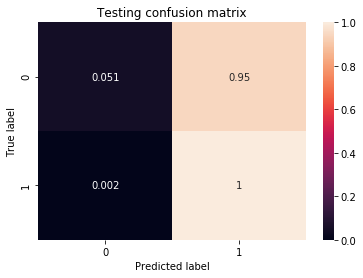

In [144]:
cm = confusion_matrix(y_test,y_test_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=clf_rf.classes_, title='Testing confusion matrix')

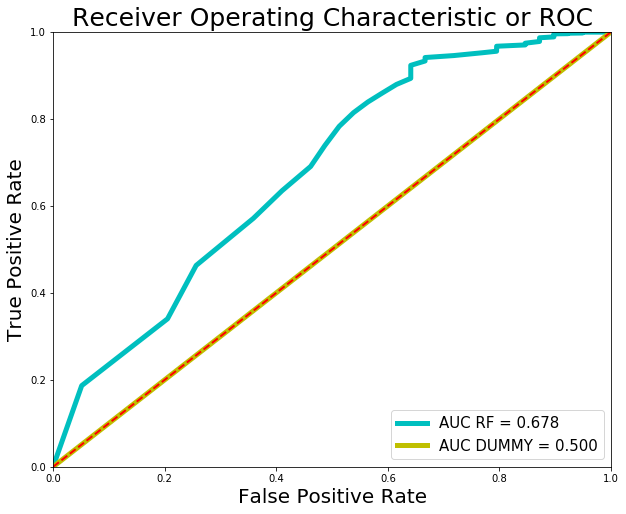

In [145]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

### RANDOM FOREST
probs = clf_rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

### DUMMY CLASSIFIER
probs_dummy = dummy_classifier.predict_proba(X_test)
preds_dummy = probs_dummy[:,1]
fpr_2, tpr_2, threshold = metrics.roc_curve(y_test, preds_dummy)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)

### PLOT
fig = plt.figure(figsize=(10,8))

plt.title('Receiver Operating Characteristic or ROC',fontsize=25)
plt.plot(fpr, tpr, 'c', label = 'AUC RF = %0.3f' % roc_auc, linewidth = 5)
plt.plot(fpr_2, tpr_2, 'y', label = 'AUC DUMMY = %0.3f' % roc_auc_2, linewidth = 5)
plt.legend(loc = 'lower right',fontsize=15)
plt.plot([0, 1], [0, 1],'r--',linewidth = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.show()

## Comprovació de resultats

In [ ]:
df_clean_prova_2 = df_clean_prova.iloc[4:5,:]
df_clean_prova_2
y_val = df_clean_prova_2["Descripcio_victimitzacio"]
select_cols = ['Edat','Codi_barri','Codi_carrer','Hora_de_dia',
                         'Mes_de_any','Dia_de_mes','Autobus','Bicicleta','Ciclomotor',
                         'Furgoneta','Motocicleta','Taxi','Turisme','Num_Victimes',
                         'Num_Vehicles_Implicats','Poblacio','Nombre_vehicles_parc','Any',
                         'Sortida_Sol','Posta_Sol','Dif_PostaoSortida_Sol','Num_Semaf_Barri',
                         'Dist_semaf','Cluster','T','HR','PPT','VV10ESC','RVX10','Conductor','Passatger','Vianant']
X_val = df_clean_prova_2[select_cols]


y_pred_resampled = clf_rf2.predict(X_val) 
print(y_pred_resampled,'Quan en realitat és: ', y_val)